In [78]:
import pandas as pd
import random
import os

In [71]:
architectures = ['test1-pol1', 'test2-pol1', 'test2-pol2']
policies = list(set([x for x in map(lambda y: y.split('-', 1)[1], architectures)]))
arch_pol_tupl_ls = [(x, y) for x, y in map(lambda x: x.split('-', 1), architectures)]
skip_layers_values = [1, 2, 3, 4, 8, 16, 32]
bench_types = ['quality', 'speed']
runs = 10

In [76]:
def executeQualityBench(arch_name, loader):
    prec = random.random()
    acc = random.random()
    rec = random.random()

    return prec, acc, rec

def executeSpeedBench(arch_name, loader):
    speed = random.random()
    return speed



d = {'run': [], 'skip_n': [], 'bench_type': [], 'arch': [], 'pol': [], 'prec': [], 'rec': [], 'acc': [], 'time': []}


loader = []

for bench_type in bench_types:
    for arch, pol in arch_pol_tupl_ls:
        for skip_n in skip_layers_values:
            for run in range(runs):
                prec = 0.0
                rec = 0.0
                acc = 0.0
                time = 0.0
                if bench_type == 'quality':
                    prec, acc, rec = executeQualityBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {prec:.6f} - {rec:.6f} - {acc:.6f}')
                elif bench_type == 'speed':
                    time = executeSpeedBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {time:.6f}')
                else:
                    raise ValueError('Benchmark type not supported')
                
                d['run'].append(run)
                d['skip_n'].append(skip_n)
                d['bench_type'].append(bench_type)
                d['arch'].append(arch)
                d['pol'].append(pol)
                d['prec'].append(prec)
                d['rec'].append(rec)
                d['acc'].append(acc)
                d['time'].append(time)

In [81]:
df = pd.DataFrame(data=d)
reports_path = os.path.join(os.getcwd())
print(reports_path)
if not os.path.isdir:
    os.mkdir(reports_path)
df.to_csv(os.path.join(reports_path, 'run.csv'), index=False)
columns = list(d.keys())
print(columns)

/home/alex/Projects/Studium/anytimeDnn/reports
['run', 'skip_n', 'bench_type', 'arch', 'pol', 'prec', 'rec', 'acc', 'time']


In [54]:
quality_df = df.query('bench_type == "quality"')
speed_df = df.query('bench_type == "speed"')

Plot for pol1
Plot for pol2


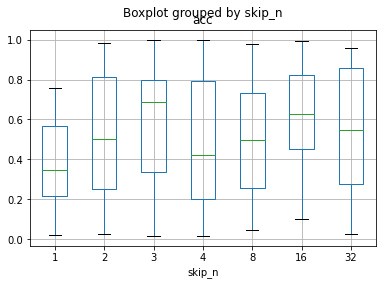

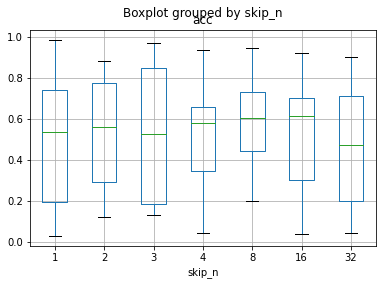

In [73]:
for policy in policies:
    t_df = quality_df.query(f'pol == "{policy}"')
    print(f'Plot for {policy}')
    t_df.boxplot(column='acc', by='skip_n')